# Calculate the relative rates of different supernovae as a function of redshift

Supernova rates are calculated by convolving the Delay time distribution with the star formation history. 
We then set the relative rates of SN Ia and Core Collapse to be 25% and 75%, respectively, at z = 0. 


References:
- Delay time distribution (DTD) for SN Ia: Graur et al (2013) https://arxiv.org/abs/1310.3495
- Delay time distribution (DTD) for SN II: Zapartas et al (2017) https://arxiv.org/abs/1701.07032
- Cosmic Star Formation Rate out to z = 8 : Behroozi et al (2013) https://arxiv.org/abs/1207.6105

In [1]:
%pylab inline
import numpy as np
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


## Calculate the Lookback Time in units of Gyr using LCDM cosmology

In [2]:
c1 = 2.9979E5 #km / s
pc= 3.085677E16 #m
c2=pc*c1*1e6
H0=70.
Om=0.30
Ol=0.7


def Efunc(x):
    return math.sqrt(Ol+Om*(1+x)**3)


convert=3600*24*365.25*10**9/(pc*10**3)#*10**9 ## Converts H0 to 1/gigayears

def t_L(z):
    t = np.zeros(len(z))
    import scipy.integrate as integrate
    for i in range(len(z)):
        x = z[i]
        test= lambda x:1.0/((1+x)*Efunc(x))
        y, err=integrate.quad(test, 0, x)
        t[i] = y/H0/convert
    return t 

In [3]:
# Star formation history = cosmic star formation rate.
# From Behroozi et al (2013)
# Note this is a function of redshift
def cosmic_SFR_B13(z):
    z0 = 1.243
    A = -0.997
    B = 0.241
    C = 0.180
    return C/(10.**(A*(z-z0)) + 10.**(B*(z-z0)))*(1./0.7)

# From Madau and Dickinson (2014)
def cosmic_SFR(z):
    return 0.7* 0.015 * (1.+z)**2.7/(1.0+((1.+z)/2.9)**5.6) # M_star/year/Mpc^3

In [4]:
# From Graur et al (2013). There are many, many different forms this can take. 
## The extra term at the end is a normalization factor
def DTD_Ia_Power_B13(delta_t, beta = -1.47): # for B13 only
    return ((delta_t < 0.04)*0.0 + ((delta_t < 1.7) & (delta_t > 0.04))*delta_t**(-0.5) + \
            np.sqrt(1.7)*(delta_t > 1.7)*delta_t**(beta))*0.2*1e-4/100.

def DTD_Ia_Power(delta_t, beta = -1.1): # for MD14 only
    return ((delta_t < 0.04)*0.0 + (delta_t > 0.04)*delta_t**(beta))*0.23*1e-4/115.

# From Zapartas et al (2017). I suggest using the binary population, but you can you single star evolution instead. See paper for 
# details. I left both in because it's complicated to type and has different units.
def DTD_cc_single(delta_t): # roughly 1/3 for Ib/c
    delta_t = delta_t*1000.
    return ((delta_t >= 3) & (delta_t  < 25))*1e-9*(-2.83 + 8.7*np.log10(delta_t) - 2.07*np.log10(delta_t)*np.log10(delta_t))*(1./delta_t) + \
        ((delta_t >= 25) & (delta_t  < 48))*1e-8*(-4.85 + 6.55*np.log10(delta_t) - 1.92*np.log10(delta_t)*np.log10(delta_t))*(1./delta_t)

def DTD_cc_binary(delta_t): # roughly 1/3 for Ib/c
    delta_t = delta_t*1000.
    return ((delta_t >= 3) & (delta_t  < 25))*1e-9*(-2.65 + 7.51*np.log10(delta_t) - 0.98*np.log10(delta_t)*np.log10(delta_t))*(1./delta_t) + \
        ((delta_t >= 25) & (delta_t  < 48))*1e-8*(-0.89 + 1.73*np.log10(delta_t) - 0.51*np.log10(delta_t)*np.log10(delta_t))*(1./delta_t) + \
        ((delta_t >= 48) & (delta_t  < 200))*1e-8*(3.46 - 2.98*np.log10(delta_t) + 0.65*np.log10(delta_t)*np.log10(delta_t))*(1./delta_t)
        
        
# Note DTDs are a function of DELTA t in usints of Gyr

The cell below deals with using reshift, delta t (delay time), and lookback time (t)

In [5]:
from scipy.interpolate import interp1d

z_inter = np.arange(0,8,0.0001)
t_inter = t_L(z_inter)

f = interp1d(t_inter, z_inter)

In [6]:
delta_t = np.arange(0.0001,12.75,0.001)
t = delta_t[::-1]
z = f(t)

con_Ia_Power_MD14 = np.convolve(cosmic_SFR(z), DTD_Ia_Power(np.array(delta_t), beta = -1.1))[0:len(t)]

con_cc_binary = np.convolve(cosmic_SFR(z), DTD_cc_binary(delta_t))[0:len(t)] 

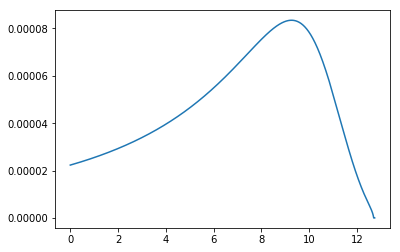

In [11]:
plt.plot(t, con_Ia_Power_MD14)

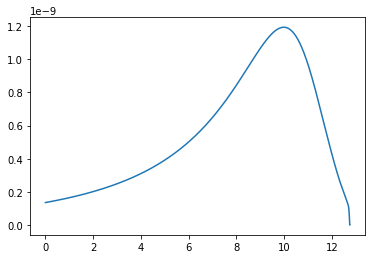

In [12]:
plt.plot(t, con_cc_binary)